# Tables for the paper

In [1]:
from pathlib import Path
from typing import List, Tuple, Dict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "Helvetica"
# })

In [3]:
INITIAL_COLUMNS = ['Method', 'which_split', 'conf_thr_train', 'conf_thr_test', 'tpr_thr',
       'cluster_method', 'mean_n_clus', 'std_n_clus', 'fusion_strat',
       'U-AP_(COOD)', 'U-F1_(COOD)', 'U-PRE_(COOD)', 'U-REC_(COOD)', 'mAP',
       'U-AP_(CMIX)', 'U-F1_(CMIX)', 'U-PRE_(CMIX)', 'U-REC_(CMIX)', 'A-OSE',
       'WI-08', 'mAP_(VOC_test)', 'Model', 'args', 'custom_hyp']

FINAL_COLUMNS = ['Method', 'cluster_method',
                 'mAP_(VOC_test)',
                 'U-AP_(COOD)', 'U-F1_(COOD)', 'U-PRE_(COOD)', 'U-REC_(COOD)', 
                 'mAP', 'U-AP_(CMIX)', 'U-F1_(CMIX)', 'U-PRE_(CMIX)', 'U-REC_(CMIX)','A-OSE', 'WI-08']

FINAL_COLUMNS_WITH_CONF_THR = ['Method', 'cluster_method',
                                'conf_thr_test',
                                'mAP_(VOC_test)',
                                'U-AP_(COOD)', 'U-F1_(COOD)', 'U-PRE_(COOD)', 'U-REC_(COOD)', 
                                'mAP', 'U-AP_(CMIX)', 'U-F1_(CMIX)', 'U-PRE_(CMIX)', 'U-REC_(CMIX)','A-OSE', 'WI-08']

COLUMNS_FOR_LATEX = ['Distance', 'Cluster Method',
                     'mAP',
                     'U-AP', 'U-F1', 'U-PRE', 'U-REC',
                     'mAP', 'U-AP', 'U-F1', 'U-PRE', 'U-REC', 'A-OSE', 'WI']

LATEX_PARAMS = {
    'index': False,
    'float_format': '%.3f',
    'bold_rows': True,
    'header': COLUMNS_FOR_LATEX,
}

NEW_NAMES_FOR_METHODS = {
    'L1_cl_stride': '$L_1$',
    'L2_cl_stride': '$L_2$',
    'Cosine_cl_stride': 'Cosine',
    'MSP': 'MSP',
    'Energy': 'Energy',
    'ODIN': 'ODIN',
    }

CLUSTER_METHODS_TO_KEEP = ['one', 'all', 'KMeans', 'KMeans_10', 'HDBSCAN', '-']
NEW_NAMES_FOR_CLUSTER_METHODS = {
    'one': '$One$',
    'all': '$All$',
    'DBSCAN': '$DBSCAN$',
    'KMeans': '$KMeans$',
    'KMeans_10': '$KMeans^{10}$',
    'HDBSCAN': '$HDBSCAN$',
    'AgglomerativeClustering': '$Agglomerative$',
}

NORMAL_TEX_PATH = Path("results/cluster_methods_results/normal_df_final.tex")
IV_TEX_PATH = Path("results/cluster_methods_results/iv_df_final.tex")

In [8]:
def search_for_paths_with_extension(path: Path, extension=".csv") -> List[Path]:
    # Recursively search for all files with the extension
    paths = []
    for p in path:
        if p.is_dir():
            paths += search_for_paths_with_extension(list(p.iterdir()), extension)
        elif p.is_file() and p.suffix == extension:
            paths.append(p)
    return paths

def convert_list_of_paths_into_df(paths: list[Path], extension=".csv"):
    # Read the documents and concat into one big dataframe
    if len(paths) == 0:
        raise ValueError("No paths found")
    
    # Extrac the .csv files from the paths
    paths = search_for_paths_with_extension(paths, extension)
    print(paths)

    for doc in paths:
        df = pd.read_csv(doc)
        # Check if all initial columns are present. If not, add them 
        if not all(col in df.columns for col in INITIAL_COLUMNS):
            for col in INITIAL_COLUMNS:
                if col not in df.columns:
                    print(f"Column {col} not found in {doc}")
                    df[col] = np.nan
        
        # Check if the dataframe is the first one
        if doc == paths[0]:
            dataframe = df
        else:  # If not, concat the dataframes
            dataframe = pd.concat([dataframe, df])    

    return dataframe

def format_df(df, columns_to_keep=None):
    # CONTENT CHANGES
    if columns_to_keep:
        dataframe = df[columns_to_keep]
    else:
        dataframe = df[FINAL_COLUMNS]
    # Display only 3 decimals
    dataframe = dataframe.round(3)
    # Convert A-OSE to int
    dataframe['A-OSE'] = dataframe['A-OSE'].astype(int)
    # Replace NaNs with -
    dataframe = dataframe.fillna('-')
    # Keep only certain rows
    dataframe = dataframe[dataframe['cluster_method'].isin(CLUSTER_METHODS_TO_KEEP)]

    # NAME CHANGES
    # Change the Method names to L1, L2, Cosine
    dataframe['Method'] = dataframe['Method'].replace(NEW_NAMES_FOR_METHODS)
    # Change the cluster method names
    dataframe['cluster_method'] = dataframe['cluster_method'].replace(NEW_NAMES_FOR_CLUSTER_METHODS)
    return dataframe


def obtain_best_values_of_columns(df, columns_to_search_max, columns_to_search_min):
    # Extract values to dicts of max and min values per
    max_values = {}
    min_values = {}
    for col in columns_to_search_max:
        df[col] = df.groupby(['Method'])[col].transform('max')
        max_values[col] = df[col].max().round(3)
    for col in columns_to_search_min:
        df[col] = df.groupby(['Method'])[col].transform('min')
        min_values[col] = df[col].min().round(3)
    return max_values, min_values  


def obtain_non_dominated_points_positions(dataframe: pd.DataFrame):
    non_dominated_points = []
    for i in range(len(dataframe)):
        is_dominated = False
        for j in range(len(dataframe)):
            if i == j:
                continue
            if dataframe['mAP'][i] < dataframe['mAP'][j] and dataframe['U-F1_(CMIX)'][i] < dataframe['U-F1_(CMIX)'][j]:
                is_dominated = True
                break
            else:
                # If the points are the same, then they are not dominated
                if dataframe['mAP'][i] == dataframe['mAP'][j] and dataframe['U-F1_(CMIX)'][i] == dataframe['U-F1_(CMIX)'][j]:
                    pass
                else:
                    # If the points are the same in one of the metrics, then check the other metric
                    if dataframe['mAP'][i] == dataframe['mAP'][j]:
                        if dataframe['U-F1_(CMIX)'][i] < dataframe['U-F1_(CMIX)'][j]:
                            is_dominated = True
                            break
                    if dataframe['U-F1_(CMIX)'][i] == dataframe['U-F1_(CMIX)'][j]:
                        if dataframe['mAP'][i] < dataframe['mAP'][j]:
                            is_dominated = True
                            break
        if not is_dominated:
            non_dominated_points.append(i)
    return non_dominated_points


## Cluster methods

### Divide documents into normal and ivis

In [5]:
documents_to_consider = Path("results/cluster_methods_results").rglob("*.csv")
documents_to_consider = list(documents_to_consider)
documents_to_consider

[PosixPath('results/cluster_methods_results/20240624_161311_cluster_methods_L1_cl_stride_silhouette_conf_train0.15_conf_test0.15.csv'),
 PosixPath('results/cluster_methods_results/20240625_234308_cluster_methods_L2Ivis_silhouette_conf_train0.15_conf_test0.15.csv'),
 PosixPath('results/cluster_methods_results/20240626_110430_cluster_methods_CosineIvis_silhouette_conf_train0.15_conf_test0.15.csv'),
 PosixPath('results/cluster_methods_results/20240625_150107_cluster_methods_L1Ivis_silhouette_conf_train0.15_conf_test0.15.csv'),
 PosixPath('results/cluster_methods_results/20240624_105143_cluster_methods_Cosine_cl_stride_silhouette_conf_train0.15_conf_test0.15.csv'),
 PosixPath('results/cluster_methods_results/20240624_123436_cluster_methods_L2_cl_stride_silhouette_conf_train0.15_conf_test0.15.csv')]

In [6]:
normal_documents = [documents_to_consider[0], documents_to_consider[5], documents_to_consider[4]]
normal_documents

[PosixPath('results/cluster_methods_results/20240624_161311_cluster_methods_L1_cl_stride_silhouette_conf_train0.15_conf_test0.15.csv'),
 PosixPath('results/cluster_methods_results/20240624_123436_cluster_methods_L2_cl_stride_silhouette_conf_train0.15_conf_test0.15.csv'),
 PosixPath('results/cluster_methods_results/20240624_105143_cluster_methods_Cosine_cl_stride_silhouette_conf_train0.15_conf_test0.15.csv')]

In [7]:
ivis_documents = [documents_to_consider[3], documents_to_consider[1], documents_to_consider[2]]
ivis_documents

[PosixPath('results/cluster_methods_results/20240625_150107_cluster_methods_L1Ivis_silhouette_conf_train0.15_conf_test0.15.csv'),
 PosixPath('results/cluster_methods_results/20240625_234308_cluster_methods_L2Ivis_silhouette_conf_train0.15_conf_test0.15.csv'),
 PosixPath('results/cluster_methods_results/20240626_110430_cluster_methods_CosineIvis_silhouette_conf_train0.15_conf_test0.15.csv')]

### Normal

In [8]:
normal_df = convert_list_of_paths_into_df(normal_documents)
normal_df.reset_index(drop=True, inplace=True)
normal_df_final = format_df(normal_df)
latex_str = normal_df_final.to_latex(**LATEX_PARAMS)
normal_df_final.to_latex(NORMAL_TEX_PATH, **LATEX_PARAMS)
normal_df_final.tail()

,Method,cluster_method,mAP_(VOC_test),U-AP_(COOD),U-F1_(COOD),U-PRE_(COOD),U-REC_(COOD),mAP,U-AP_(CMIX),U-F1_(CMIX),U-PRE_(CMIX),U-REC_(CMIX),A-OSE,WI-08
21,Cosine,$All$,0.591,0.160,0.206,0.686,0.121,0.376,0.020,0.113,0.220,0.076,211,0.125
23,Cosine,$KMeans$,0.623,0.158,0.199,0.694,0.116,0.406,0.022,0.097,0.239,0.061,247,0.126
26,Cosine,$KMeans^{10}$,0.583,0.163,0.235,0.699,0.141,0.380,0.022,0.124,0.241,0.083,193,0.107
27,Cosine,$HDBSCAN$,0.631,0.159,0.212,0.692,0.125,0.415,0.025,0.111,0.270,0.070,224,0.119
28,Cosine,$Agglomerative$,0.647,0.160,0.187,0.718,0.107,0.416,0.022,0.093,0.240,0.058,254,0.128


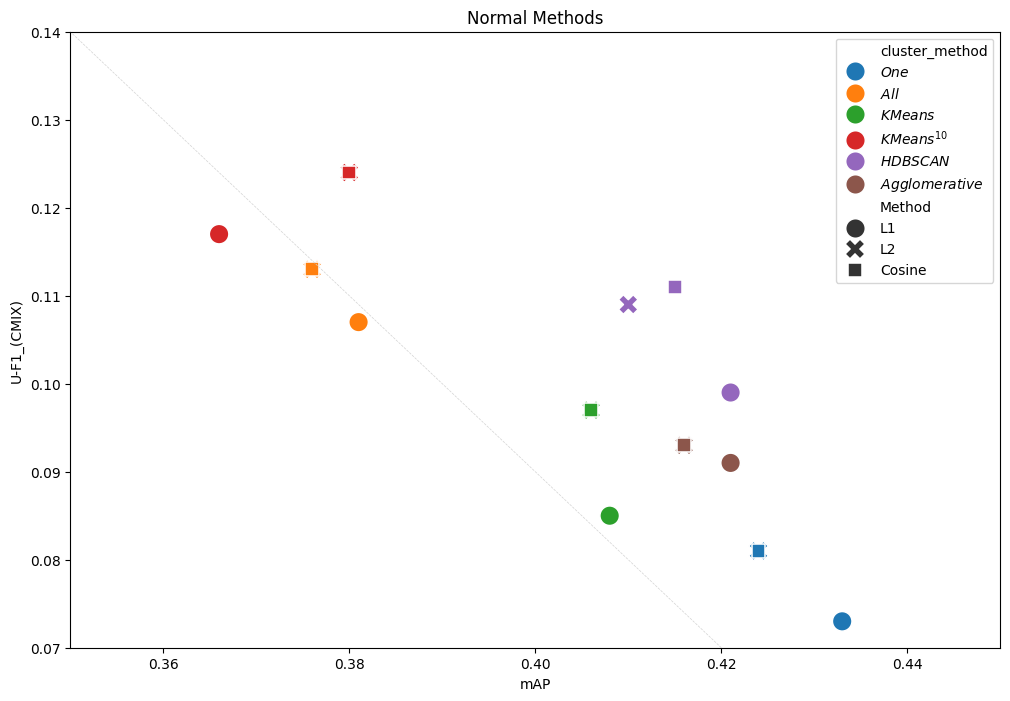

In [9]:
# Convert the dataframe to a figure where the axes are the mAP and the U-F1
# Each method should be one type of point
# Each cluster method one color

# Create the figure

#sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=normal_df_final, x='mAP', y='U-F1_(CMIX)', hue='cluster_method', style='Method',
                # Define marker size
                s=200,
                #size='A-OSE', sizes=(100, 200), 
                ax=ax)
# Set the axis mAP=[0.35, 0.45] and U-F1=[0.7, 0.14]
ax.set_xlim(0.35, 0.45)
ax.set_ylim(0.07, 0.14)
# Instead of vertical and horizontal lines for the grid, use -45 degrees angled lines
# Define the limits of the plot
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()

# Create angled grid lines
for x in np.arange(xlim[0], xlim[1], 5):
    plt.plot([xlim[0], xlim[1]], [ylim[0] + x, ylim[0] + x - (xlim[1] - xlim[0])], color='lightgrey', linestyle='--', linewidth=0.5)

for y in np.arange(ylim[0], ylim[1], 5):
    plt.plot([xlim[0] + y, xlim[0] + y - (ylim[1] - ylim[0])], [ylim[0], ylim[1]], color='lightgrey', linestyle='--', linewidth=0.5)
plt.title("Normal Methods")
plt.show()


In [10]:
def format_latex_str(latex_str: str, mark_greater_values: Dict[str, float], mark_lower_values: Dict[str, float]) -> str:
    # Split the string into lines
    lines = latex_str.splitlines()
    # Add the midrules
    lines.insert(10, '\\midrule')
    lines.insert(17, '\\midrule')
    lines.insert(24, '\\midrule')
    # Join the lines back into a single string    
    final_latex_str = '\n'.join(lines)
    # Mark in bold and underline the greatest value of each column
    for col, value in mark_greater_values.items():
        # For each value, search for it in the string and change it to bold
        final_latex_str = final_latex_str.replace(str(value), '\\underline{\\textbf{' + str(value) + '}}')
    for col, value in mark_lower_values.items():
        # For each value, search for it in the string and change it to bold
        final_latex_str = final_latex_str.replace(str(value), '\\textbf{' + str(value) + '}')
    return final_latex_str

In [11]:
max_values, min_values = obtain_best_values_of_columns(normal_df, columns_to_search_max=FINAL_COLUMNS[2:-2], columns_to_search_min=FINAL_COLUMNS[-2:])
final_latex_str = format_latex_str(latex_str, max_values, min_values)
# Save the final string to the file
with open(NORMAL_TEX_PATH, 'w') as f:
    f.write(final_latex_str)

### Ivis

In [12]:
ivis_df = convert_list_of_paths_into_df(ivis_documents)
ivis_df.reset_index(drop=True, inplace=True)
ivis_df_final = format_df(ivis_df)
ivis_df_final.to_latex(IV_TEX_PATH, **LATEX_PARAMS)
ivis_df_final.tail()

,Method,cluster_method,mAP_(VOC_test),U-AP_(COOD),U-F1_(COOD),U-PRE_(COOD),U-REC_(COOD),mAP,U-AP_(CMIX),U-F1_(CMIX),U-PRE_(CMIX),U-REC_(CMIX),A-OSE,WI-08
21,CosineIvis,$All$,0.560,0.171,0.307,0.695,0.197,0.378,0.025,0.146,0.270,0.100,142,0.087
23,CosineIvis,$KMeans$,0.541,0.239,0.327,0.710,0.212,0.372,0.053,0.152,0.286,0.103,133,0.081
26,CosineIvis,$KMeans^{10}$,0.536,0.242,0.339,0.708,0.223,0.369,0.052,0.154,0.281,0.106,126,0.080
27,CosineIvis,$HDBSCAN$,0.543,0.241,0.333,0.717,0.217,0.381,0.026,0.147,0.278,0.100,142,0.088
28,CosineIvis,$Agglomerative$,0.545,0.241,0.331,0.713,0.215,0.377,0.051,0.150,0.279,0.103,135,0.081


## Pareto fronts

In [56]:
folder_to_consider = Path("results/pareto_fronts")
documents_to_consider = folder_to_consider.rglob("*.csv")
documents_to_consider = list(documents_to_consider)
df = convert_list_of_paths_into_df(documents_to_consider)
df.reset_index(drop=True, inplace=True)
df_final = format_df(df, columns_to_keep=FINAL_COLUMNS_WITH_CONF_THR)
df_final.tail()

,Method,cluster_method,conf_thr_test,mAP_(VOC_test),U-AP_(COOD),U-F1_(COOD),U-PRE_(COOD),U-REC_(COOD),mAP,U-AP_(CMIX),U-F1_(CMIX),U-PRE_(CMIX),U-REC_(CMIX),A-OSE,WI-08
92,Cosine,$KMeans^{10}$,0.100,0.576,0.164,0.262,0.649,0.164,0.381,0.045,0.145,0.245,0.103,201,0.109
93,Cosine,$KMeans^{10}$,0.050,0.566,0.163,0.291,0.555,0.197,0.374,0.044,0.159,0.217,0.126,232,0.114
94,Cosine,$KMeans^{10}$,0.010,0.529,0.225,0.331,0.412,0.276,0.341,0.042,0.173,0.162,0.185,285,0.118
95,Cosine,$KMeans^{10}$,0.005,0.505,0.259,0.330,0.346,0.314,0.334,0.054,0.163,0.134,0.208,325,0.123
96,Cosine,$KMeans^{10}$,0.001,0.450,0.268,0.276,0.213,0.395,0.278,0.051,0.139,0.091,0.292,410,0.126


### Results without printing the pareto front

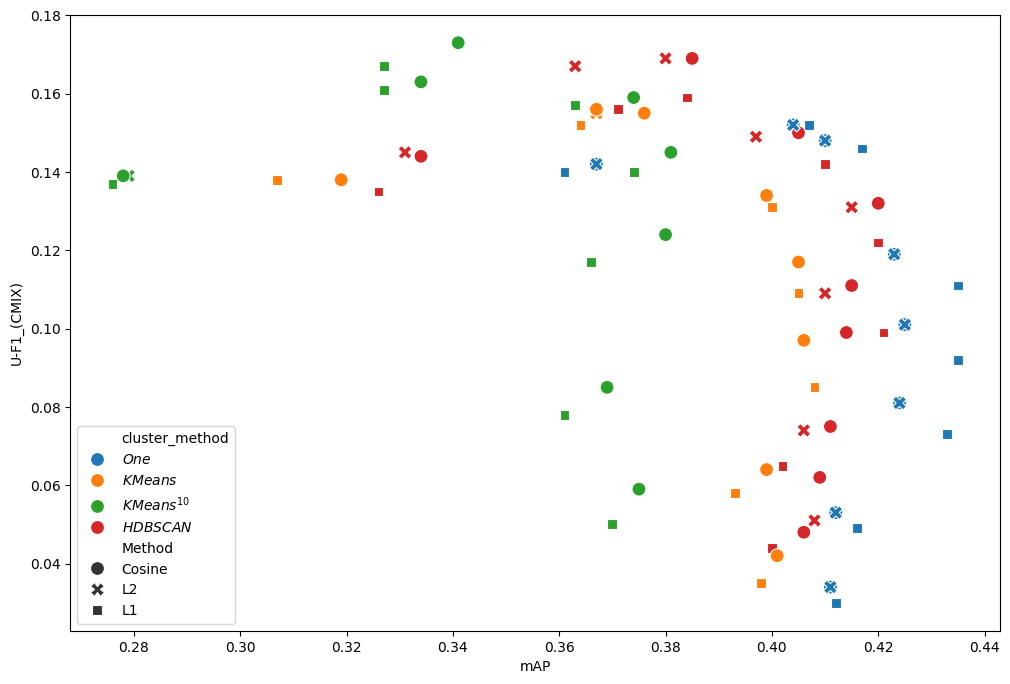

In [14]:
#sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=df_final, x='mAP', y='U-F1_(CMIX)', hue='cluster_method', style='Method',
                # Define marker size
                s=100,
                #size='A-OSE', sizes=(1, 200), size_norm=(0, 1000),
                ax=ax,
                legend='brief')
plt.show()

<Axes: xlabel='mAP', ylabel='U-F1_(CMIX)'>

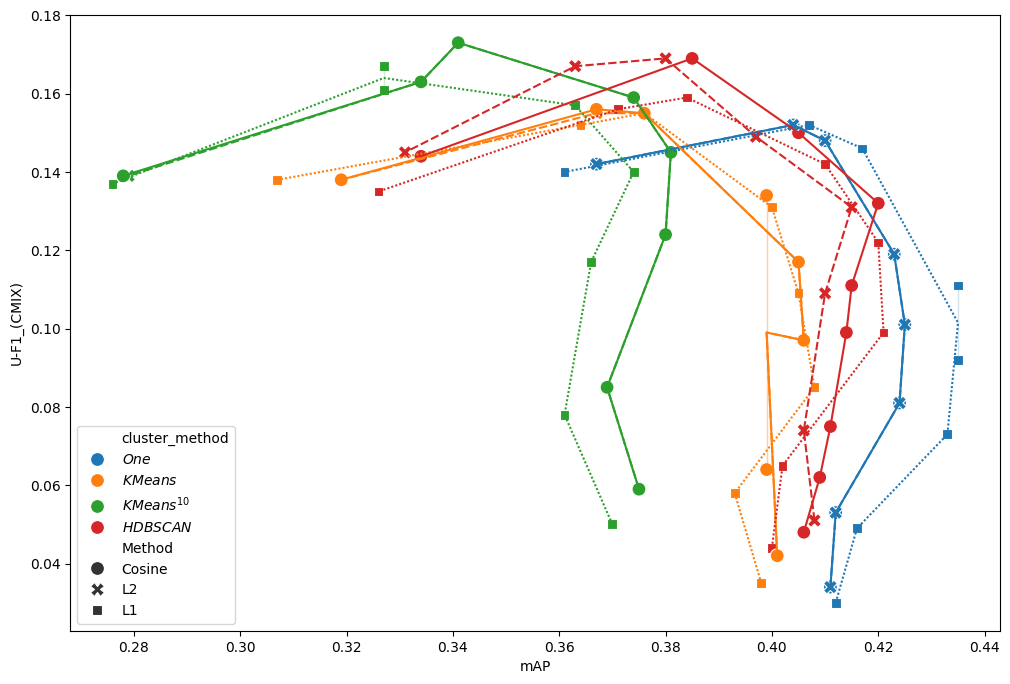

In [15]:
# Convert the dataframe to a figure where the axes are the mAP and the U-F1
# Each method should be one type of point
# Each cluster method one color

# Create the figure

#sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=df_final, x='mAP', y='U-F1_(CMIX)', hue='cluster_method', style='Method',
                # Define marker size
                s=100,
                #size='A-OSE', sizes=(1, 200), size_norm=(0, 1000),
                ax=ax,
                legend='brief')
# Create a line between the points
sns.lineplot(data=df_final, x='mAP', y='U-F1_(CMIX)', hue='cluster_method', style='Method', ax=ax, sort=False, legend=False)

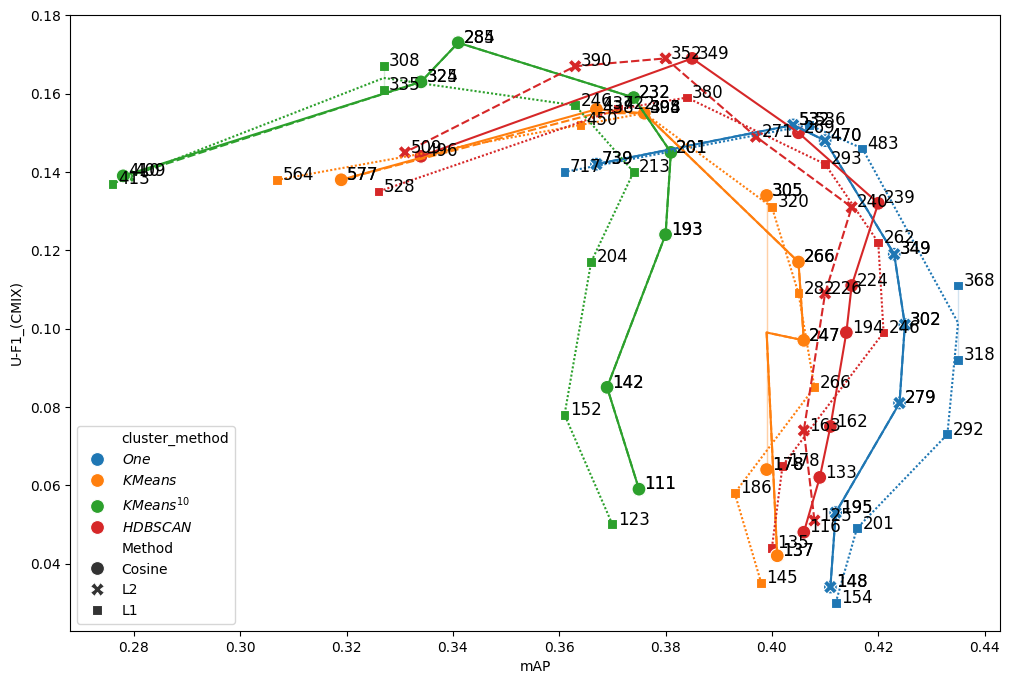

In [16]:
#sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=df_final, x='mAP', y='U-F1_(CMIX)', hue='cluster_method', style='Method',
                # Define marker size
                s=100,
                #size='A-OSE', sizes=(1, 200), size_norm=(0, 1000),
                ax=ax,
                legend='brief')
# Create a line between the points
sns.lineplot(data=df_final, x='mAP', y='U-F1_(CMIX)', hue='cluster_method', style='Method', ax=ax, sort=False, legend=False)

# Add a marker in each point with the value of A-OSE
for i in range(len(df_final)):
    #ax.text(df_final['mAP'][i]+0.003, df_final['U-F1_(CMIX)'][i], df_final['conf_thr_test'][i], fontsize=12)
    # Put the value of A-OSE to the left of the point
    #ax.text(df_final['mAP'][i]-0.008, df_final['U-F1_(CMIX)'][i], df_final['A-OSE'][i], fontsize=12)
    # Put the value of A-OSE to the right of the point
    ax.text(df_final['mAP'][i]+0.001, df_final['U-F1_(CMIX)'][i], df_final['A-OSE'][i], fontsize=12)

### With Non-dominated solutions marked

In [17]:
palette = sns.color_palette("tab10")
palette

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

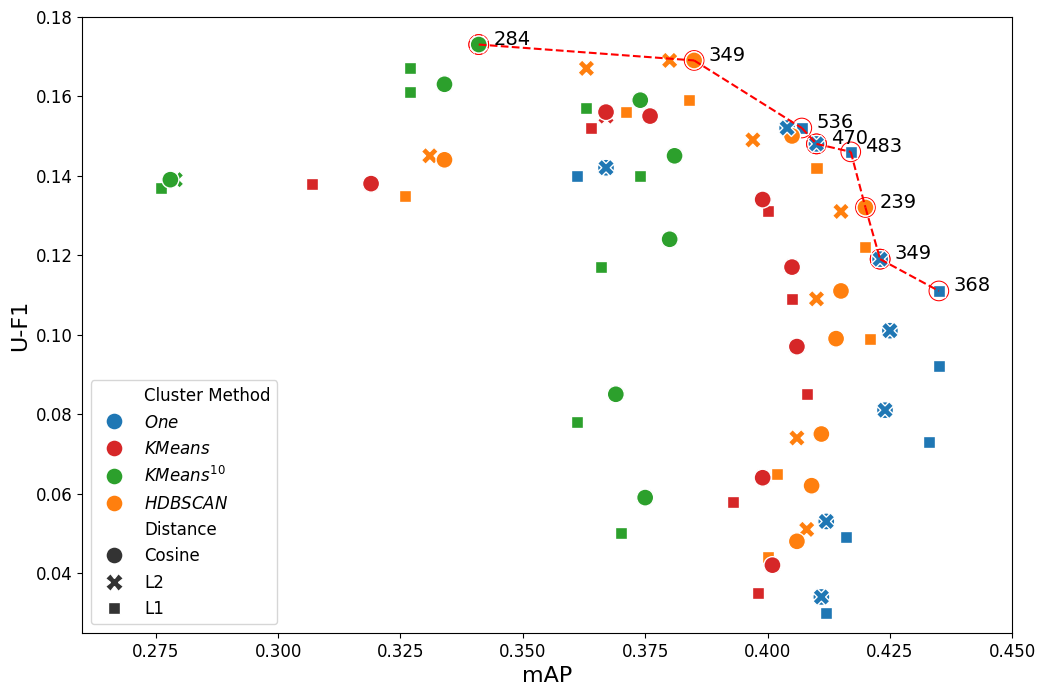

In [42]:
# Colors for the different cluster methods
palette = sns.color_palette("tab10")
colors_for_methods = [palette[0], palette[3], palette[2], palette[1]]

# Change the column name cluster_method to Cluster Method and Method to Distance
df_final = df_final.rename(columns={'cluster_method': 'Cluster Method'})
df_final = df_final.rename(columns={'Method': 'Distance'})

# Constants
XLIM = (0.26, 0.45)
YLIM = (0.025, 0.18)
FONTSIZE_XY_LABELS = 16
FONTSIZE_AOSE = 14
FONTSIZE_LEGEND = 'large'
FONTSIZE_TICKS = 12
MARKER_SIZE = 150
MARKER_SIZE_NON_DOMINATED = 200
LINEWIDTH_NON_DOMINATED_MARKER = 0.75
LINEWIDTH_NON_DOMINATED_LINE= 1.5
COLOR_NON_DOMINATED = 'red'

# Figure
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=df_final, x='mAP', y='U-F1_(CMIX)', hue='Cluster Method', style='Distance',
                # Define sizes
                s=MARKER_SIZE, 
                #size='A-OSE', sizes=(1, 200), size_norm=(0, 1000),
                palette=colors_for_methods, ax=ax, legend='brief')
plt.xlim(XLIM)
plt.ylim(YLIM)
plt.xlabel('mAP', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.ylabel('U-F1', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.xticks(fontsize=FONTSIZE_TICKS)
plt.yticks(fontsize=FONTSIZE_TICKS)

# Search for the non dominated points
# These are any points that have no other point with a higher mAP and U-F1 at the same time
# For each point, check if there is any other point with a higher mAP and U-F1
# If there is not, then the point is non-dominated
non_dominated_points = obtain_non_dominated_points_positions(df_final)

# Highlight the non-dominated points
for i in non_dominated_points:
    ax.scatter(df_final['mAP'][i], df_final['U-F1_(CMIX)'][i], s=MARKER_SIZE_NON_DOMINATED, 
               #c='red',
               facecolors='none', marker='o', zorder=0, edgecolors=COLOR_NON_DOMINATED, linewidths=LINEWIDTH_NON_DOMINATED_MARKER)

# Add a line connecting the non-dominated points in descending order of U-F1
non_dominated_points.sort(key=lambda x: df_final['U-F1_(CMIX)'][x], reverse=True)
for i in range(len(non_dominated_points)-1):
    x = [df_final['mAP'][non_dominated_points[i]], df_final['mAP'][non_dominated_points[i+1]]]
    y = [df_final['U-F1_(CMIX)'][non_dominated_points[i]], df_final['U-F1_(CMIX)'][non_dominated_points[i+1]]]
    ax.plot(x, y, c=COLOR_NON_DOMINATED, linestyle='--', linewidth=LINEWIDTH_NON_DOMINATED_LINE)

# Add text to the non-dominated points with the value of A-OSE
added_text_points = []
for i in non_dominated_points:
    # Store the positions of the points
    x = df_final['mAP'][i]
    y = df_final['U-F1_(CMIX)'][i]
    if (x, y) in added_text_points:
        continue
        ax.text(df_final['mAP'][i]-0.007, df_final['U-F1_(CMIX)'][i], df_final['A-OSE'][i], fontsize=FONTSIZE_AOSE)
    else:
        ax.text(df_final['mAP'][i]+0.003, df_final['U-F1_(CMIX)'][i], df_final['A-OSE'][i], fontsize=FONTSIZE_AOSE)
    added_text_points.append((x, y))

# Increase legend size
legend = ax.legend(fontsize=FONTSIZE_LEGEND)   # You can use 'small', 'medium', 'large', 'x-large', etc.
plt.savefig(folder_to_consider / 'pareto_fronts.pdf', bbox_inches='tight')
plt.show()

/home/tri110414/nfs_home/yolo-pruebas/venv-yolo/lib/python3.10/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/home/tri110414/nfs_home/yolo-pruebas/venv-yolo/lib/python3.10/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/home/tri110414/nfs_home/yolo-pruebas/venv-yolo/lib/python3.10/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/home/tri110414/nfs_home/yolo-pruebas/venv-yolo/lib/python3.10/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


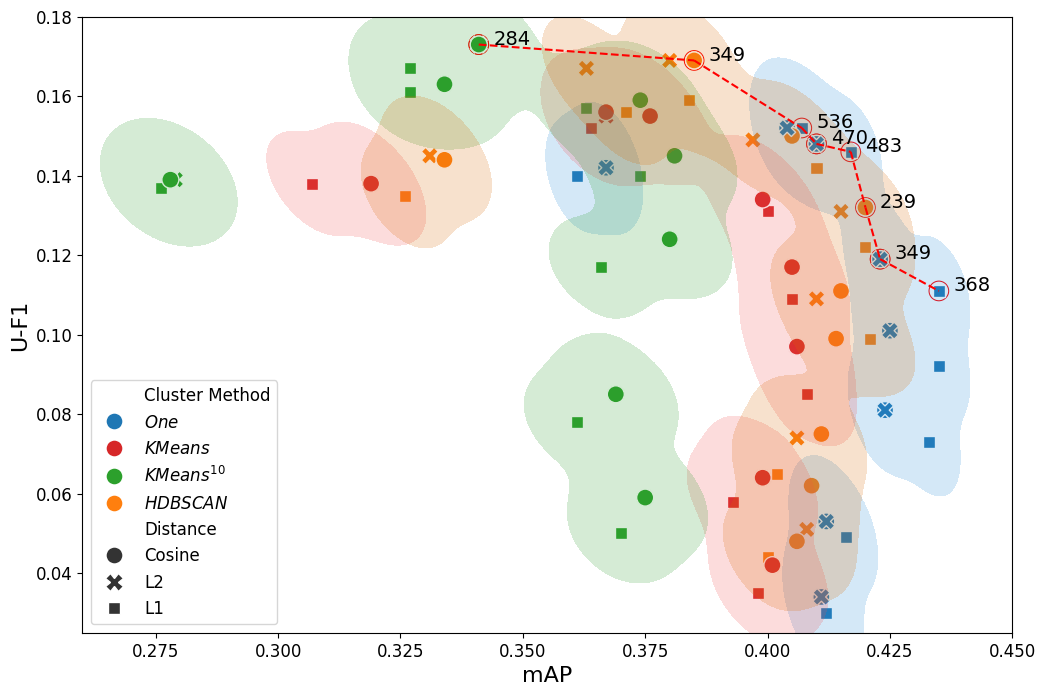

In [55]:
# Colors for the different cluster methods
palette = sns.color_palette("tab10")
colors_for_methods = [palette[0], palette[3], palette[2], palette[1]]

# Change the column name cluster_method to Cluster Method and Method to Distance
df_final = df_final.rename(columns={'cluster_method': 'Cluster Method'})
df_final = df_final.rename(columns={'Method': 'Distance'})

# Constants
XLIM = (0.26, 0.45)
YLIM = (0.025, 0.18)
FONTSIZE_XY_LABELS = 16
FONTSIZE_AOSE = 14
FONTSIZE_LEGEND = 'large'
FONTSIZE_TICKS = 12
MARKER_SIZE = 150
MARKER_SIZE_NON_DOMINATED = 200
LINEWIDTH_NON_DOMINATED_MARKER = 0.75
LINEWIDTH_NON_DOMINATED_LINE= 1.5
COLOR_NON_DOMINATED = 'red'

# Figure
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=df_final, x='mAP', y='U-F1_(CMIX)', hue='Cluster Method', style='Distance',
                # Define sizes
                s=MARKER_SIZE, 
                #size='A-OSE', sizes=(1, 200), size_norm=(0, 1000),
                palette=colors_for_methods, ax=ax, legend='brief')

# Adding shaded areas with adjustable amplitude (bandwidth)
bw_adjust_value = 0.3  # Adjust this value to modulate the amplitude
alpha_value = 0.2

# Adding shaded areas
for method, color in zip(df_final['Cluster Method'].unique(), colors_for_methods):
    subset = df_final[df_final['Cluster Method'] == method]
    sns.kdeplot(x=subset['mAP'], y=subset['U-F1_(CMIX)'], ax=ax, fill=True, color=color, alpha=alpha_value, legend=False, bw_adjust=bw_adjust_value,
                 linewidth=0, levels=2)

plt.xlim(XLIM)
plt.ylim(YLIM)
plt.xlabel('mAP', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.ylabel('U-F1', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.xticks(fontsize=FONTSIZE_TICKS)
plt.yticks(fontsize=FONTSIZE_TICKS)


# Search for the non dominated points
# These are any points that have no other point with a higher mAP and U-F1 at the same time
# For each point, check if there is any other point with a higher mAP and U-F1
# If there is not, then the point is non-dominated
non_dominated_points = obtain_non_dominated_points_positions(df_final)

# Highlight the non-dominated points
for i in non_dominated_points:
    ax.scatter(df_final['mAP'][i], df_final['U-F1_(CMIX)'][i], s=MARKER_SIZE_NON_DOMINATED, 
               #c='red',
               facecolors='none', marker='o', zorder=0, edgecolors=COLOR_NON_DOMINATED, linewidths=LINEWIDTH_NON_DOMINATED_MARKER)

# Add a line connecting the non-dominated points in descending order of U-F1
non_dominated_points.sort(key=lambda x: df_final['U-F1_(CMIX)'][x], reverse=True)
for i in range(len(non_dominated_points)-1):
    x = [df_final['mAP'][non_dominated_points[i]], df_final['mAP'][non_dominated_points[i+1]]]
    y = [df_final['U-F1_(CMIX)'][non_dominated_points[i]], df_final['U-F1_(CMIX)'][non_dominated_points[i+1]]]
    ax.plot(x, y, c=COLOR_NON_DOMINATED, linestyle='--', linewidth=LINEWIDTH_NON_DOMINATED_LINE)

# Add text to the non-dominated points with the value of A-OSE
added_text_points = []
for i in non_dominated_points:
    # Store the positions of the points
    x = df_final['mAP'][i]
    y = df_final['U-F1_(CMIX)'][i]
    if (x, y) in added_text_points:
        continue
        ax.text(df_final['mAP'][i]-0.007, df_final['U-F1_(CMIX)'][i], df_final['A-OSE'][i], fontsize=FONTSIZE_AOSE)
    else:
        ax.text(df_final['mAP'][i]+0.003, df_final['U-F1_(CMIX)'][i], df_final['A-OSE'][i], fontsize=FONTSIZE_AOSE)
    added_text_points.append((x, y))

# Increase legend size
legend = ax.legend(fontsize=FONTSIZE_LEGEND)   # You can use 'small', 'medium', 'large', 'x-large', etc.
plt.savefig(folder_to_consider / 'pareto_fronts.pdf', bbox_inches='tight')
plt.show()

# RQ2. Resutls with logits

In [5]:
folder_to_consider = Path("results/pareto_fronts_wtih_logits")
documents_to_consider = folder_to_consider.rglob("*.csv")
documents_to_consider = list(documents_to_consider)
df = convert_list_of_paths_into_df(documents_to_consider)
df.reset_index(drop=True, inplace=True)
df_final = format_df(df, columns_to_keep=FINAL_COLUMNS_WITH_CONF_THR)
df_final.tail()

,Method,cluster_method,conf_thr_test,mAP_(VOC_test),U-AP_(COOD),U-F1_(COOD),U-PRE_(COOD),U-REC_(COOD),mAP,U-AP_(CMIX),U-F1_(CMIX),U-PRE_(CMIX),U-REC_(CMIX),A-OSE,WI-08
116,ODIN,-,0.100,0.709,0.234,0.361,0.642,0.251,0.441,0.087,0.167,0.266,0.122,131,0.079
117,ODIN,-,0.050,0.709,0.234,0.384,0.563,0.291,0.441,0.087,0.180,0.226,0.150,134,0.079
118,ODIN,-,0.010,0.716,0.284,0.381,0.398,0.365,0.443,0.102,0.179,0.155,0.213,135,0.080
119,ODIN,-,0.005,0.716,0.284,0.363,0.332,0.400,0.443,0.102,0.169,0.130,0.243,135,0.080
120,ODIN,-,0.001,0.716,0.314,0.285,0.204,0.477,0.443,0.111,0.134,0.084,0.328,137,0.080


In [6]:
# Show method unique values
df_final['Method'].unique()

array(['Cosine', '$L_2$', 'MSP', '$L_1$', 'Energy', 'ODIN'], dtype=object)

/tmp/ipykernel_214284/703521093.py:24: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data=df_final, x='mAP', y='U-F1_(CMIX)', hue='Cluster Method', style='Distance',
/home/tri110414/nfs_home/yolo-pruebas/venv-yolo/lib/python3.10/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/home/tri110414/nfs_home/yolo-pruebas/venv-yolo/lib/python3.10/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/home/tri110414/nfs_home/yolo-pruebas/venv-yolo/lib/python3.10/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/home/tri110414/nfs_home/yolo-pruebas/venv-yolo/lib/python3.10/site-packages/seaborn/distributions.py:1176: UserWarning: The f

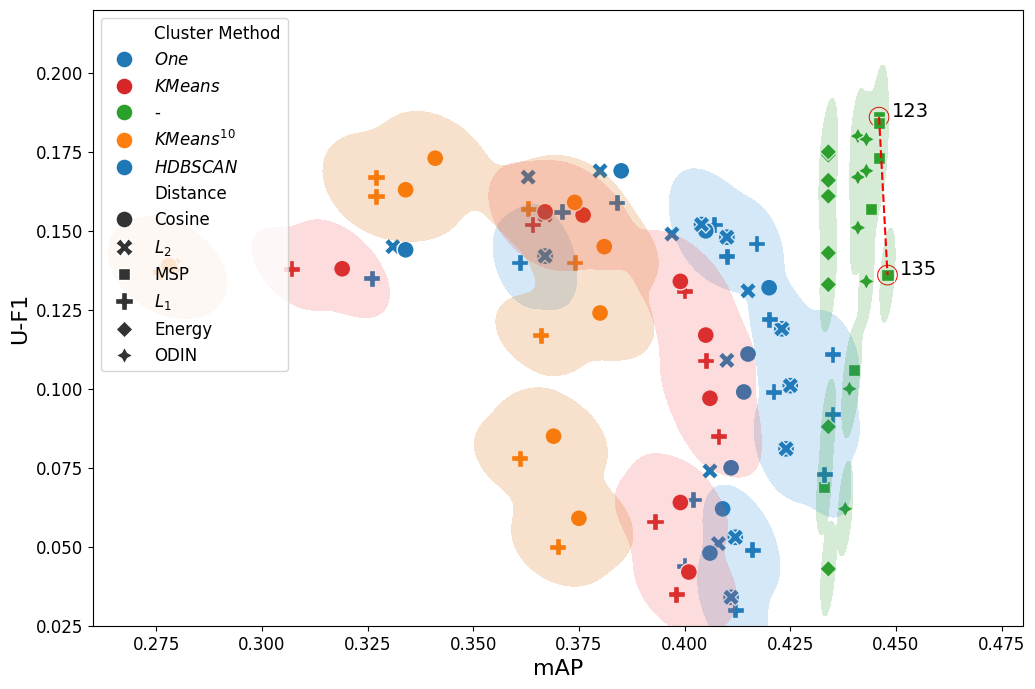

In [7]:
# Colors for the different cluster methods
palette = sns.color_palette("tab10")
colors_for_methods = [palette[0], palette[3], palette[2], palette[1]]

# Change the column name cluster_method to Cluster Method and Method to Distance
df_final = df_final.rename(columns={'cluster_method': 'Cluster Method'})
df_final = df_final.rename(columns={'Method': 'Distance'})

# Constants
XLIM = (0.26, 0.48)
YLIM = (0.025, 0.22)
FONTSIZE_XY_LABELS = 16
FONTSIZE_AOSE = 14
FONTSIZE_LEGEND = 'large'
FONTSIZE_TICKS = 12
MARKER_SIZE = 150
MARKER_SIZE_NON_DOMINATED = 200
LINEWIDTH_NON_DOMINATED_MARKER = 0.75
LINEWIDTH_NON_DOMINATED_LINE= 1.5
COLOR_NON_DOMINATED = 'red'

# Figure
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=df_final, x='mAP', y='U-F1_(CMIX)', hue='Cluster Method', style='Distance',
                # Define sizes
                s=MARKER_SIZE, 
                #size='A-OSE', sizes=(1, 200), size_norm=(0, 1000),
                palette=colors_for_methods, ax=ax, legend='brief')

# Adding shaded areas with adjustable amplitude (bandwidth)
bw_adjust_value = 0.3  # Adjust this value to modulate the amplitude
alpha_value = 0.2

# Adding shaded areas
for method, color in zip(df_final['Cluster Method'].unique(), colors_for_methods):
    subset = df_final[df_final['Cluster Method'] == method]
    sns.kdeplot(x=subset['mAP'], y=subset['U-F1_(CMIX)'], ax=ax, fill=True, color=color, alpha=alpha_value, legend=False, bw_adjust=bw_adjust_value,
                 linewidth=0, levels=2)

plt.xlim(XLIM)
plt.ylim(YLIM)
plt.xlabel('mAP', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.ylabel('U-F1', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.xticks(fontsize=FONTSIZE_TICKS)
plt.yticks(fontsize=FONTSIZE_TICKS)


# Search for the non dominated points
# These are any points that have no other point with a higher mAP and U-F1 at the same time
# For each point, check if there is any other point with a higher mAP and U-F1
# If there is not, then the point is non-dominated
non_dominated_points = obtain_non_dominated_points_positions(df_final)

# Highlight the non-dominated points
for i in non_dominated_points:
    ax.scatter(df_final['mAP'][i], df_final['U-F1_(CMIX)'][i], s=MARKER_SIZE_NON_DOMINATED, 
               #c='red',
               facecolors='none', marker='o', zorder=0, edgecolors=COLOR_NON_DOMINATED, linewidths=LINEWIDTH_NON_DOMINATED_MARKER)

# Add a line connecting the non-dominated points in descending order of U-F1
non_dominated_points.sort(key=lambda x: df_final['U-F1_(CMIX)'][x], reverse=True)
for i in range(len(non_dominated_points)-1):
    x = [df_final['mAP'][non_dominated_points[i]], df_final['mAP'][non_dominated_points[i+1]]]
    y = [df_final['U-F1_(CMIX)'][non_dominated_points[i]], df_final['U-F1_(CMIX)'][non_dominated_points[i+1]]]
    ax.plot(x, y, c=COLOR_NON_DOMINATED, linestyle='--', linewidth=LINEWIDTH_NON_DOMINATED_LINE)

# Add text to the non-dominated points with the value of A-OSE
added_text_points = []
for i in non_dominated_points:
    # Store the positions of the points
    x = df_final['mAP'][i]
    y = df_final['U-F1_(CMIX)'][i]
    if (x, y) in added_text_points:
        continue
        ax.text(df_final['mAP'][i]-0.007, df_final['U-F1_(CMIX)'][i], df_final['A-OSE'][i], fontsize=FONTSIZE_AOSE)
    else:
        ax.text(df_final['mAP'][i]+0.003, df_final['U-F1_(CMIX)'][i], df_final['A-OSE'][i], fontsize=FONTSIZE_AOSE)
    added_text_points.append((x, y))

# Increase legend size
legend = ax.legend(fontsize=FONTSIZE_LEGEND)   # You can use 'small', 'medium', 'large', 'x-large', etc.
plt.savefig(folder_to_consider / 'pareto_fronts.pdf', bbox_inches='tight')
plt.show()

### With CosineIvis and logits

In [9]:
folder_to_consider = Path("results/pareto_fronts_with_ivis_and_logits")
documents_to_consider = folder_to_consider.rglob("*.csv")
documents_to_consider = list(documents_to_consider)
df = convert_list_of_paths_into_df(documents_to_consider)
df.reset_index(drop=True, inplace=True)
df_final = format_df(df, columns_to_keep=FINAL_COLUMNS_WITH_CONF_THR)
df_final.tail()

[PosixPath('results/pareto_fronts_with_ivis_and_logits/20240712_165027_conf_thr_test_Cosine_cl_stride_one.csv'), PosixPath('results/pareto_fronts_with_ivis_and_logits/20240712_165118_conf_thr_test_L2_cl_stride_KMeans.csv'), PosixPath('results/pareto_fronts_with_ivis_and_logits/20240713_151540_conf_thr_test_MSP.csv'), PosixPath('results/pareto_fronts_with_ivis_and_logits/20240713_161713_conf_thr_test_CosineIvis_KMeans.csv'), PosixPath('results/pareto_fronts_with_ivis_and_logits/20240712_165432_conf_thr_test_L2_cl_stride_KMeans_10.csv'), PosixPath('results/pareto_fronts_with_ivis_and_logits/20240713_181123_conf_thr_test_CosineIvis_KMeans_10.csv'), PosixPath('results/pareto_fronts_with_ivis_and_logits/20240713_151627_conf_thr_test_CosineIvis_one.csv'), PosixPath('results/pareto_fronts_with_ivis_and_logits/20240712_161755_conf_thr_test_L1_cl_stride_KMeans_10.csv'), PosixPath('results/pareto_fronts_with_ivis_and_logits/20240712_194645_conf_thr_test_L1_cl_stride_one.csv'), PosixPath('results

,Method,cluster_method,conf_thr_test,mAP_(VOC_test),U-AP_(COOD),U-F1_(COOD),U-PRE_(COOD),U-REC_(COOD),mAP,U-AP_(CMIX),U-F1_(CMIX),U-PRE_(CMIX),U-REC_(CMIX),A-OSE,WI-08
148,ODIN,-,0.100,0.709,0.234,0.361,0.642,0.251,0.441,0.087,0.167,0.266,0.122,131,0.079
149,ODIN,-,0.050,0.709,0.234,0.384,0.563,0.291,0.441,0.087,0.180,0.226,0.150,134,0.079
150,ODIN,-,0.010,0.716,0.284,0.381,0.398,0.365,0.443,0.102,0.179,0.155,0.213,135,0.080
151,ODIN,-,0.005,0.716,0.284,0.363,0.332,0.400,0.443,0.102,0.169,0.130,0.243,135,0.080
152,ODIN,-,0.001,0.716,0.314,0.285,0.204,0.477,0.443,0.111,0.134,0.084,0.328,137,0.080


/tmp/ipykernel_214284/2953437976.py:24: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data=df_final, x='mAP', y='U-F1_(CMIX)', hue='Cluster Method', style='Distance',
/home/tri110414/nfs_home/yolo-pruebas/venv-yolo/lib/python3.10/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/home/tri110414/nfs_home/yolo-pruebas/venv-yolo/lib/python3.10/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/home/tri110414/nfs_home/yolo-pruebas/venv-yolo/lib/python3.10/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/home/tri110414/nfs_home/yolo-pruebas/venv-yolo/lib/python3.10/site-packages/seaborn/distributions.py:1176: UserWarning: The 

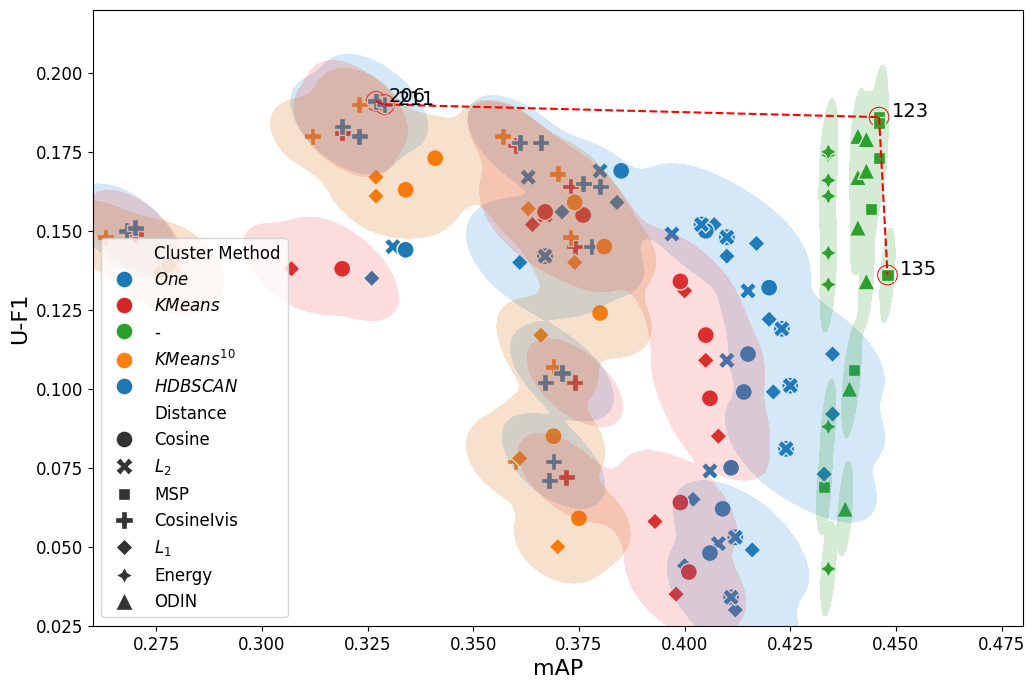

In [10]:

# Colors for the different cluster methods
palette = sns.color_palette("tab10")
colors_for_methods = [palette[0], palette[3], palette[2], palette[1]]

# Change the column name cluster_method to Cluster Method and Method to Distance
df_final = df_final.rename(columns={'cluster_method': 'Cluster Method'})
df_final = df_final.rename(columns={'Method': 'Distance'})

# Constants
XLIM = (0.26, 0.48)
YLIM = (0.025, 0.22)
FONTSIZE_XY_LABELS = 16
FONTSIZE_AOSE = 14
FONTSIZE_LEGEND = 'large'
FONTSIZE_TICKS = 12
MARKER_SIZE = 150
MARKER_SIZE_NON_DOMINATED = 200
LINEWIDTH_NON_DOMINATED_MARKER = 0.75
LINEWIDTH_NON_DOMINATED_LINE= 1.5
COLOR_NON_DOMINATED = 'red'

# Figure
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=df_final, x='mAP', y='U-F1_(CMIX)', hue='Cluster Method', style='Distance',
                # Define sizes
                s=MARKER_SIZE, 
                #size='A-OSE', sizes=(1, 200), size_norm=(0, 1000),
                palette=colors_for_methods, ax=ax, legend='brief')

# Adding shaded areas with adjustable amplitude (bandwidth)
bw_adjust_value = 0.3  # Adjust this value to modulate the amplitude
alpha_value = 0.2

# Adding shaded areas
for method, color in zip(df_final['Cluster Method'].unique(), colors_for_methods):
    subset = df_final[df_final['Cluster Method'] == method]
    sns.kdeplot(x=subset['mAP'], y=subset['U-F1_(CMIX)'], ax=ax, fill=True, color=color, alpha=alpha_value, legend=False, bw_adjust=bw_adjust_value,
                 linewidth=0, levels=2)

plt.xlim(XLIM)
plt.ylim(YLIM)
plt.xlabel('mAP', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.ylabel('U-F1', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.xticks(fontsize=FONTSIZE_TICKS)
plt.yticks(fontsize=FONTSIZE_TICKS)


# Search for the non dominated points
# These are any points that have no other point with a higher mAP and U-F1 at the same time
# For each point, check if there is any other point with a higher mAP and U-F1
# If there is not, then the point is non-dominated
non_dominated_points = obtain_non_dominated_points_positions(df_final)

# Highlight the non-dominated points
for i in non_dominated_points:
    ax.scatter(df_final['mAP'][i], df_final['U-F1_(CMIX)'][i], s=MARKER_SIZE_NON_DOMINATED, 
               #c='red',
               facecolors='none', marker='o', zorder=0, edgecolors=COLOR_NON_DOMINATED, linewidths=LINEWIDTH_NON_DOMINATED_MARKER)

# Add a line connecting the non-dominated points in descending order of U-F1
non_dominated_points.sort(key=lambda x: df_final['U-F1_(CMIX)'][x], reverse=True)
for i in range(len(non_dominated_points)-1):
    x = [df_final['mAP'][non_dominated_points[i]], df_final['mAP'][non_dominated_points[i+1]]]
    y = [df_final['U-F1_(CMIX)'][non_dominated_points[i]], df_final['U-F1_(CMIX)'][non_dominated_points[i+1]]]
    ax.plot(x, y, c=COLOR_NON_DOMINATED, linestyle='--', linewidth=LINEWIDTH_NON_DOMINATED_LINE)

# Add text to the non-dominated points with the value of A-OSE
added_text_points = []
for i in non_dominated_points:
    # Store the positions of the points
    x = df_final['mAP'][i]
    y = df_final['U-F1_(CMIX)'][i]
    if (x, y) in added_text_points:
        continue
        ax.text(df_final['mAP'][i]-0.007, df_final['U-F1_(CMIX)'][i], df_final['A-OSE'][i], fontsize=FONTSIZE_AOSE)
    else:
        ax.text(df_final['mAP'][i]+0.003, df_final['U-F1_(CMIX)'][i], df_final['A-OSE'][i], fontsize=FONTSIZE_AOSE)
    added_text_points.append((x, y))

# Increase legend size
legend = ax.legend(fontsize=FONTSIZE_LEGEND)   # You can use 'small', 'medium', 'large', 'x-large', etc.
plt.savefig(folder_to_consider / 'pareto_fronts.pdf', bbox_inches='tight')
plt.show()

### Ivis with distance methods

In [13]:
folder_to_consider = Path("results/pareto_fronts_with_ivis")
documents_to_consider = folder_to_consider.rglob("*.csv")
documents_to_consider = list(documents_to_consider)
df = convert_list_of_paths_into_df(documents_to_consider)
df.reset_index(drop=True, inplace=True)
df_final = format_df(df, columns_to_keep=FINAL_COLUMNS_WITH_CONF_THR)
df_final.tail()

,Method,cluster_method,conf_thr_test,mAP_(VOC_test),U-AP_(COOD),U-F1_(COOD),U-PRE_(COOD),U-REC_(COOD),mAP,U-AP_(CMIX),U-F1_(CMIX),U-PRE_(CMIX),U-REC_(CMIX),A-OSE,WI-08
124,Cosine,$KMeans^{10}$,0.100,0.576,0.164,0.262,0.649,0.164,0.381,0.045,0.145,0.245,0.103,201,0.109
125,Cosine,$KMeans^{10}$,0.050,0.566,0.163,0.291,0.555,0.197,0.374,0.044,0.159,0.217,0.126,232,0.114
126,Cosine,$KMeans^{10}$,0.010,0.529,0.225,0.331,0.412,0.276,0.341,0.042,0.173,0.162,0.185,285,0.118
127,Cosine,$KMeans^{10}$,0.005,0.505,0.259,0.330,0.346,0.314,0.334,0.054,0.163,0.134,0.208,325,0.123
128,Cosine,$KMeans^{10}$,0.001,0.450,0.268,0.276,0.213,0.395,0.278,0.051,0.139,0.091,0.292,410,0.126


/home/tri110414/nfs_home/yolo-pruebas/venv-yolo/lib/python3.10/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/home/tri110414/nfs_home/yolo-pruebas/venv-yolo/lib/python3.10/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/home/tri110414/nfs_home/yolo-pruebas/venv-yolo/lib/python3.10/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/home/tri110414/nfs_home/yolo-pruebas/venv-yolo/lib/python3.10/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


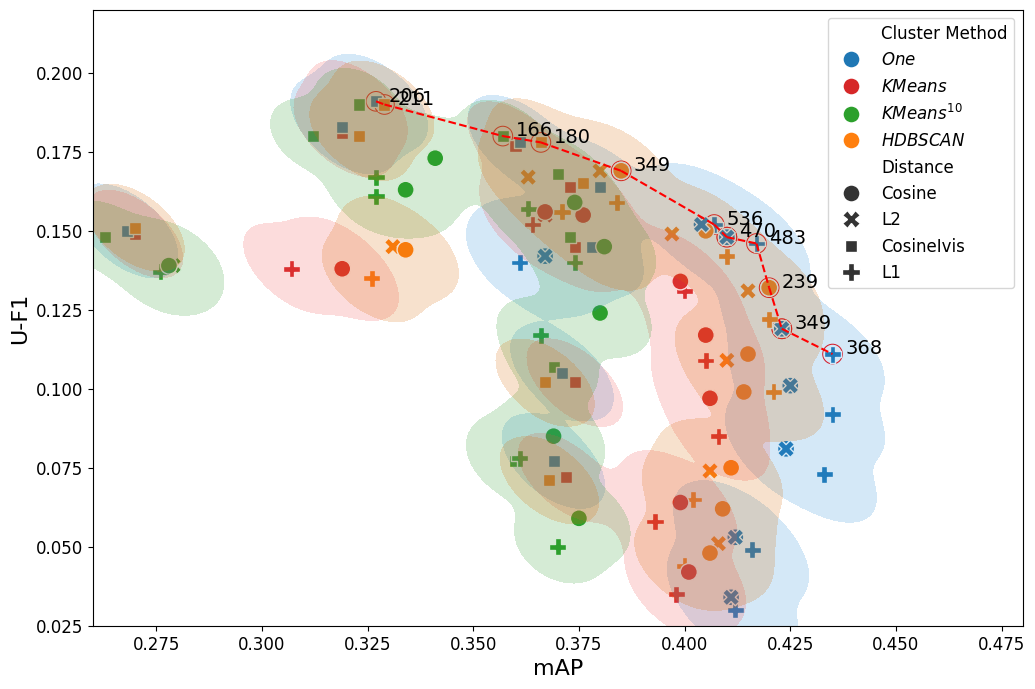

In [14]:
# Colors for the different cluster methods
palette = sns.color_palette("tab10")
colors_for_methods = [palette[0], palette[3], palette[2], palette[1]]

# Change the column name cluster_method to Cluster Method and Method to Distance
df_final = df_final.rename(columns={'cluster_method': 'Cluster Method'})
df_final = df_final.rename(columns={'Method': 'Distance'})

# Constants
XLIM = (0.26, 0.48)
YLIM = (0.025, 0.22)
FONTSIZE_XY_LABELS = 16
FONTSIZE_AOSE = 14
FONTSIZE_LEGEND = 'large'
FONTSIZE_TICKS = 12
MARKER_SIZE = 150
MARKER_SIZE_NON_DOMINATED = 200
LINEWIDTH_NON_DOMINATED_MARKER = 0.75
LINEWIDTH_NON_DOMINATED_LINE= 1.5
COLOR_NON_DOMINATED = 'red'

# Figure
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=df_final, x='mAP', y='U-F1_(CMIX)', hue='Cluster Method', style='Distance',
                # Define sizes
                s=MARKER_SIZE, 
                #size='A-OSE', sizes=(1, 200), size_norm=(0, 1000),
                palette=colors_for_methods, ax=ax, legend='brief')

# Adding shaded areas with adjustable amplitude (bandwidth)
bw_adjust_value = 0.3  # Adjust this value to modulate the amplitude
alpha_value = 0.2

# Adding shaded areas
for method, color in zip(df_final['Cluster Method'].unique(), colors_for_methods):
    subset = df_final[df_final['Cluster Method'] == method]
    sns.kdeplot(x=subset['mAP'], y=subset['U-F1_(CMIX)'], ax=ax, fill=True, color=color, alpha=alpha_value, legend=False, bw_adjust=bw_adjust_value,
                 linewidth=0, levels=2)

plt.xlim(XLIM)
plt.ylim(YLIM)
plt.xlabel('mAP', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.ylabel('U-F1', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.xticks(fontsize=FONTSIZE_TICKS)
plt.yticks(fontsize=FONTSIZE_TICKS)


# Search for the non dominated points
# These are any points that have no other point with a higher mAP and U-F1 at the same time
# For each point, check if there is any other point with a higher mAP and U-F1
# If there is not, then the point is non-dominated
non_dominated_points = obtain_non_dominated_points_positions(df_final)

# Highlight the non-dominated points
for i in non_dominated_points:
    ax.scatter(df_final['mAP'][i], df_final['U-F1_(CMIX)'][i], s=MARKER_SIZE_NON_DOMINATED, 
               #c='red',
               facecolors='none', marker='o', zorder=0, edgecolors=COLOR_NON_DOMINATED, linewidths=LINEWIDTH_NON_DOMINATED_MARKER)

# Add a line connecting the non-dominated points in descending order of U-F1
non_dominated_points.sort(key=lambda x: df_final['U-F1_(CMIX)'][x], reverse=True)
for i in range(len(non_dominated_points)-1):
    x = [df_final['mAP'][non_dominated_points[i]], df_final['mAP'][non_dominated_points[i+1]]]
    y = [df_final['U-F1_(CMIX)'][non_dominated_points[i]], df_final['U-F1_(CMIX)'][non_dominated_points[i+1]]]
    ax.plot(x, y, c=COLOR_NON_DOMINATED, linestyle='--', linewidth=LINEWIDTH_NON_DOMINATED_LINE)

# Add text to the non-dominated points with the value of A-OSE
added_text_points = []
for i in non_dominated_points:
    # Store the positions of the points
    x = df_final['mAP'][i]
    y = df_final['U-F1_(CMIX)'][i]
    if (x, y) in added_text_points:
        continue
        ax.text(df_final['mAP'][i]-0.007, df_final['U-F1_(CMIX)'][i], df_final['A-OSE'][i], fontsize=FONTSIZE_AOSE)
    else:
        ax.text(df_final['mAP'][i]+0.003, df_final['U-F1_(CMIX)'][i], df_final['A-OSE'][i], fontsize=FONTSIZE_AOSE)
    added_text_points.append((x, y))

# Increase legend size
legend = ax.legend(fontsize=FONTSIZE_LEGEND)   # You can use 'small', 'medium', 'large', 'x-large', etc.
plt.savefig(folder_to_consider / 'pareto_fronts.pdf', bbox_inches='tight')
plt.show()